## GradientBoostingClassifier
в качестве примера самый простой dataset из 3 строк и дерево будет не max_depth=2

In [1]:
import pandas as pd 
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_graphviz

from pathlib import Path
from pydotplus import graph_from_dot_data
from IPython.display import Image

In [2]:
data = pd.DataFrame(data={'Age':[12, 87, 44, 56, 24], 'y':[1, 1, 0, 0, 1]}, columns=['Age', 'y'])
y = data['y']


X_train = data[['Age']]
data

,Age,y
0,12,1
1,87,1
2,44,0
3,56,0
4,24,1


In [3]:
# Visualization 
def plot_tree(estimator):
    # Get the tree number 1
    sub_tree = clf.estimators_[estimator, 0]

    dot_data = export_graphviz(
        sub_tree,
        out_file=None, filled=True, rounded=True,
        special_characters=True,
        proportion=False, impurity=False, # enable them if you want
    )
    graph = graph_from_dot_data(dot_data)
    png = graph.create_png()

    Path(f'./out_{estimator+1}.png').write_bytes(png)
    return Image(png)

#### Типовая функция GradientBoostingClassifier 

In [4]:
learning_rate=0.1
clf = GradientBoostingClassifier(n_estimators=2, learning_rate=learning_rate, max_depth=2, random_state=0).fit(X_train, y)
clf.predict(X_train)


array([1, 1, 0, 0, 1], dtype=int64)

output values считаются в переменных $log(odds)= log(\frac{p}{1-p})$

prediction будет в вероятностях probability
$prediction = \frac{1}{1-exp^{-log(odds)}}$


initial prediction $p$- это вероятность начальная, а output мерится в $log(odds)$ 

если использовать параметр initial = 'zero' значает что у всех будет вероятность 0.5 вне зависимости от долей начальных,
иначе средняя по тренировочному dataset


In [5]:
initial_prediction = y.mean() # 3/5

data['initial_prediction'] = initial_prediction
data['output_0'] = np.log(initial_prediction/(1-initial_prediction))
data['residuals_0'] = data['y'] - initial_prediction

data


,Age,y,initial_prediction,output_0,residuals_0
0,12,1,0.6,0.405465,0.4
1,87,1,0.6,0.405465,0.4
2,44,0,0.6,0.405465,-0.6
3,56,0,0.6,0.405465,-0.6
4,24,1,0.6,0.405465,0.4


первое дерево, которое делает predict residuals_0

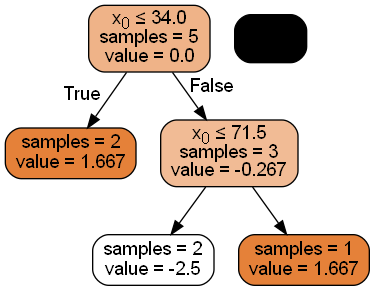

In [6]:
plot_tree(0)

теперь посчитаем output values сами

In [7]:
# влево идут
mask = (data['Age']<=34)
data[mask]


,Age,y,initial_prediction,output_0,residuals_0
0,12,1,0.6,0.405465,0.4
4,24,1,0.6,0.405465,0.4


output в ячейке (суммирование по количеству samples  в листе)   
Residuals - residuals которые попали в лист  
p_{previous,i} - предыдущая вероятность на прошлом дереве у строки, которая попала в лист  

output = $\frac{\sum_i{Residuals}}{\sum{[p_{previous,i}*(1-p_{previous})]}}$


## output = $\frac{\sum_i{Residuals}}{\sum_i{[p_{previous,i}*(1-p_{previous, i})]}}$

In [8]:
# как посчитать output value для  узла 
mask = (data['Age']<=34)
data.loc[mask, 'output_1'] =  data.loc[mask, 'residuals_0'].sum()/(data.loc[mask, 'initial_prediction']*(1-data.loc[mask, 'initial_prediction']).sum())
data

,Age,y,initial_prediction,output_0,residuals_0,output_1
0,12,1,0.6,0.405465,0.4,1.666667
1,87,1,0.6,0.405465,0.4,NaN
2,44,0,0.6,0.405465,-0.6,NaN
3,56,0,0.6,0.405465,-0.6,NaN
4,24,1,0.6,0.405465,0.4,1.666667


In [9]:
# как посчитать output value для  узла 
mask = (data['Age']>=71.5)
data.loc[mask, 'output_1'] =  data.loc[mask, 'residuals_0'].sum()/(data.loc[mask, 'initial_prediction']*(1-data.loc[mask, 'initial_prediction']).sum())
data

,Age,y,initial_prediction,output_0,residuals_0,output_1
0,12,1,0.6,0.405465,0.4,1.666667
1,87,1,0.6,0.405465,0.4,1.666667
2,44,0,0.6,0.405465,-0.6,NaN
3,56,0,0.6,0.405465,-0.6,NaN
4,24,1,0.6,0.405465,0.4,1.666667


In [10]:
# как посчитать output value для  узла 
mask = (data['Age']<=71.5)&((data['Age']>34))
data.loc[mask, 'output_1'] =  data.loc[mask, 'residuals_0'].sum()/(data.loc[mask, 'initial_prediction']*(1-data.loc[mask, 'initial_prediction']).sum())
data

,Age,y,initial_prediction,output_0,residuals_0,output_1
0,12,1,0.6,0.405465,0.4,1.666667
1,87,1,0.6,0.405465,0.4,1.666667
2,44,0,0.6,0.405465,-0.6,-2.500000
3,56,0,0.6,0.405465,-0.6,-2.500000
4,24,1,0.6,0.405465,0.4,1.666667


теперь расчитаем на вероятность

In [11]:
output_total = data['output_0'] + learning_rate*data['output_1']
data['prediction_1'] = 1/(1+np.exp(-output_total))
data

,Age,y,initial_prediction,output_0,residuals_0,output_1,prediction_1
0,12,1,0.6,0.405465,0.4,1.666667,0.639255
1,87,1,0.6,0.405465,0.4,1.666667,0.639255
2,44,0,0.6,0.405465,-0.6,-2.500000,0.538788
3,56,0,0.6,0.405465,-0.6,-2.500000,0.538788
4,24,1,0.6,0.405465,0.4,1.666667,0.639255


In [12]:
#  сравниваем с реализацией бустинга на первом дереве. ура!!! совпали
# for ypred in clf.staged_predict_proba(X_train):
#     print(ypred)
#     break
list(clf.staged_predict_proba(X_train))[0]

array([[0.36074507, 0.63925493],
       [0.36074507, 0.63925493],
       [0.46121182, 0.53878818],
       [0.46121182, 0.53878818],
       [0.36074507, 0.63925493]])

второе дерево смотрим

рассчитаем residuals, которые будем минимизировать вторым деревом

In [13]:
data['residuals_1'] = data['y'] - data['prediction_1']

data

,Age,y,initial_prediction,output_0,residuals_0,output_1,prediction_1,residuals_1
0,12,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745
1,87,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745
2,44,0,0.6,0.405465,-0.6,-2.500000,0.538788,-0.538788
3,56,0,0.6,0.405465,-0.6,-2.500000,0.538788,-0.538788
4,24,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745


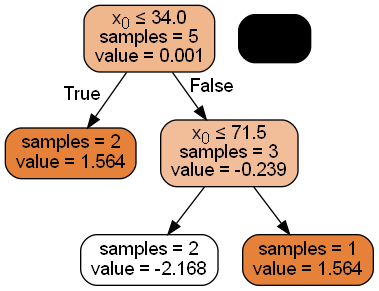

In [14]:
# Get the tree number 2
plot_tree(1)

In [15]:
# как посчитать output value для второго узла
mask = (data['Age']<=34)
data.loc[mask, 'output_2'] =  data.loc[mask, 'residuals_1'].sum()/((data.loc[mask, 'prediction_1']*(1-data.loc[mask, 'prediction_1'])).sum())

mask = (data['Age']>71.5)
data.loc[mask, 'output_2'] =  data.loc[mask, 'residuals_1'].sum()/((data.loc[mask, 'prediction_1']*(1-data.loc[mask, 'prediction_1'])).sum())

mask = (data['Age']<=71.5)&((data['Age']>34))
data.loc[mask, 'output_2'] =  data.loc[mask, 'residuals_1'].sum()/((data.loc[mask, 'prediction_1']*(1-data.loc[mask, 'prediction_1'])).sum())
data


,Age,y,initial_prediction,output_0,residuals_0,output_1,prediction_1,residuals_1,output_2
0,12,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745,1.564321
1,87,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745,1.564321
2,44,0,0.6,0.405465,-0.6,-2.500000,0.538788,-0.538788,-2.168201
3,56,0,0.6,0.405465,-0.6,-2.500000,0.538788,-0.538788,-2.168201
4,24,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745,1.564321


теперь расчитаем на вероятность

In [16]:
output_total = data['output_0'] + learning_rate*data['output_1'] + learning_rate*data['output_2']
data['prediction_2'] = 1/(1+np.exp(-output_total))
data

,Age,y,initial_prediction,output_0,residuals_0,output_1,prediction_1,residuals_1,output_2,prediction_2
0,12,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745,1.564321,0.674490
1,87,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745,1.564321,0.674490
2,44,0,0.6,0.405465,-0.6,-2.500000,0.538788,-0.538788,-2.168201,0.484666
3,56,0,0.6,0.405465,-0.6,-2.500000,0.538788,-0.538788,-2.168201,0.484666
4,24,1,0.6,0.405465,0.4,1.666667,0.639255,0.360745,1.564321,0.674490


In [17]:
#  сравниваем с реализацией бустинга. ура!!! совпала
list(clf.staged_predict_proba(X_train))[1]

array([[0.32550995, 0.67449005],
       [0.32550995, 0.67449005],
       [0.51533394, 0.48466606],
       [0.51533394, 0.48466606],
       [0.32550995, 0.67449005]])

In [18]:
#  получили аналогичный результат как и prediction_2
clf.predict_proba(X_train)

array([[0.32550995, 0.67449005],
       [0.32550995, 0.67449005],
       [0.51533394, 0.48466606],
       [0.51533394, 0.48466606],
       [0.32550995, 0.67449005]])